In [1]:
# import modules
import arcgis
from arcgis.gis import GIS
from IPython.display import clear_output,display
import ipywidgets as widgets
from arcgis import features
import csv
from arcgis.geoanalytics import manage_data
from arcgis.features import FeatureLayer
import urllib.request
import io
import requests
import pandas as pd
import os
from os import path
from io import StringIO
from arcgis import geometry #use geometry module to project Long,Lat to X and Y
from copy import deepcopy
from datetime import datetime, timedelta, date
import numpy as np
from dateutil.relativedelta import relativedelta, MO

In [2]:
username='iglesias'
password='inia1977'

gis = GIS("https://gis.inia.es/portal/home/index.html", username, password)

print("Logged in as "+ str(gis.properties.user.username))

Logged in as iglesias


In [10]:
#Descarga de datos portal de la FAO de los ultimos 4 meses
#https://europe-west1-fao-empres-re.cloudfunctions.net/getEventsInfluenzaAvian?start_date=2021-07-22&end_date=2021-10-22&serotype=all&diagnosis_status=confirmed&animal_type=all
# url = 'https://us-central1-fao-empres-re.cloudfunctions.net/getEventsASF' 5/31/2022

today = date.today()
today_str = str(today)
past_months = str(today + relativedelta(months=-1)) 

# today = date.today()
# today_str = '2022-09-06'
# past_months = '2022-05-18'

start_url = 'https://europe-west1-fao-empres-re.cloudfunctions.net/getEventsInfluenzaAvian?start_date='
start_date = past_months
m_url = '&end_date='
end_date = today_str
end_url = '&serotype=all&diagnosis_status=confirmed&animal_type=all'

url = start_url+start_date+m_url+end_date+end_url

datos= urllib.request.urlopen(url)
datos=pd.read_csv(StringIO(bytearray(datos.read()).decode("utf-8")),encoding=("ISO-8859-1"))

# Añadir "NULL" a los datos vacios 
datos = datos.fillna('NULL')

#Filtro para quedarnos con la primera palabra en el campo de species
datos['species'] = datos['species'].apply(lambda x: x.split(',')[0])


# #redondear lat y lon para solucionar problema a la hora de subir el csv a Portal
datos['lat'] = datos['lat'].apply(lambda x: np.round(x, decimals=2))
datos['lon'] = datos['lon'].apply(lambda x: np.round(x, decimals=2))

In [11]:
#Frame de los datos
datosCO = pd.DataFrame(data=datos)
datosCO

,event_id,disease,serotype,lat,lon,locality,country,region,location,observation_date,report_date,display_date,species,diagnosis_source,humans_affected,humans_deaths
0,330799,Influenza - Avian,H5N8 HPAI,30.59,114.30,Wuhan zoo,China,Asia,"Wuhan zoo, China, Asia",2022-08-31,2022-09-01,2022-08-31,Wild,National authorities,NULL,NULL
1,330606,Influenza - Avian,H5N1 HPAI,40.46,-3.70,Madrid,Spain,Europe,"Madrid, Spain, Europe",2022-08-22,2022-09-01,2022-08-22,Wild,OIE,NULL,NULL
2,330532,Influenza - Avian,H5N1 HPAI,42.26,-8.78,Cangas,Spain,Europe,"Cangas, Spain, Europe",2022-08-15,2022-09-01,2022-08-15,Wild,OIE,NULL,NULL
3,330531,Influenza - Avian,H5N1 HPAI,43.30,-3.47,Castro-Urdiales,Spain,Europe,"Castro-Urdiales, Spain, Europe",2022-08-19,2022-09-01,2022-08-19,Wild,OIE,NULL,NULL
4,330530,Influenza - Avian,H5N1 HPAI,42.93,-2.28,Muskiz,Spain,Europe,"Muskiz, Spain, Europe",2022-08-21,2022-09-01,2022-08-21,Wild,OIE,NULL,NULL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,330005,Influenza - Avian,H5N1 HPAI,52.08,-4.70,St Dogmaels,U.K. of Great Britain and Northern Ireland,Europe,"St Dogmaels, U.K. of Great Britain and Norther...",2022-08-18,2022-08-26,2022-08-18,Wild,OIE,NULL,NULL
110,330004,Influenza - Avian,H5N1 HPAI,50.96,0.15,"Framfield, East Sussex",U.K. of Great Britain and Northern Ireland,Europe,"Framfield, East Sussex, U.K. of Great Britain ...",2022-08-17,2022-08-26,2022-08-17,Wild,OIE,NULL,NULL
111,330003,Influenza - Avian,H5N1 HPAI,50.22,-5.38,"Gwithian, Cornwall",U.K. of Great Britain and Northern Ireland,Europe,"Gwithian, Cornwall, U.K. of Great Britain and ...",2022-08-17,2022-08-26,2022-08-17,Wild,OIE,NULL,NULL
112,329601,Influenza - Avian,H5N1 HPAI,55.84,-5.13,"Ettrick Bay, Argyll and Bute",U.K. of Great Britain and Northern Ireland,Europe,"Ettrick Bay, Argyll and Bute, U.K. of Great Br...",2022-08-11,2022-08-19,2022-08-11,Wild,OIE,NULL,NULL


In [12]:
#Frame to CSV y lectura
datos.to_csv('aviar_actual.csv',index=False, header=True, )
# df = pd.read_csv('hASF2021.csv', sep=";")
df = pd.read_csv('aviar_actual.csv', sep='\r')

print(df)

    event_id,disease,serotype,lat,lon,locality,country,region,location,observation_date,report_date,display_date,species,diagnosis_source,humans_affected,humans_deaths
0    330799,Influenza - Avian,H5N8 HPAI,30.59,114.3...                                                                                                                 
1    330606,Influenza - Avian,H5N1 HPAI,40.46,-3.7,...                                                                                                                 
2    330532,Influenza - Avian,H5N1 HPAI,42.26,-8.78...                                                                                                                 
3    330531,Influenza - Avian,H5N1 HPAI,43.3,-3.47,...                                                                                                                 
4    330530,Influenza - Avian,H5N1 HPAI,42.93,-2.28...                                                                                                          

In [13]:
#Almacenamiento del csv
rutaCsv='aviar_actual.csv'
inputRuta=path.abspath(rutaCsv)

print(inputRuta)

C:\Users\carlo\Documents\Innvel\INIA\proyectoAviar\codigosFinales\aviar_actual.csv


In [14]:
item_properties = { 
    'title': 'aviar_actual',
    'tags': 'cvs',
    'overwrite': 'True'
    }


csv_item = gis.content.add(item_properties, inputRuta, folder = "cisa_visores")
csv_id = csv_item.id


print(csv_id)

82c35aa3f5dc48128266ed044cc7f666


In [15]:
display(csv_item)

<Item title:"aviar_actual" type:CSV owner:iglesias>

In [16]:
csv_lyr = csv_item.publish(overwrite = True, item_id = csv_id)
display(csv_lyr)

<Item title:"aviar_actual" type:Feature Layer Collection owner:iglesias>

In [17]:
print(csv_lyr.id)

91953e5f44a3422cbcd3d9fe268deb8c


<Item title:"histAviar" type:Feature Layer Collection owner:iglesias>
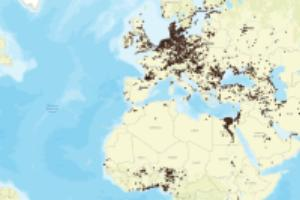

In [18]:
# Obtener item del historico
historico_id = "ccda52705369466c86a6fff3e7ed2db9"

historico_item = gis.content.get(historico_id)
historico_item

In [19]:
#Eliminar datos de los ultimos 4 meses en adelante
feature_historico =  gis.content.get(historico_id).layers[0]

today = date.today()
today_str = str(today)
past_months_str = str(today + relativedelta(months=-1)) 

# today_str = '2022-09-06'
# past_months_str = '2022-05-24' 

f1 = 'report_date >= TIMESTAMP'
f2 = '\''
f3 = past_months_str
f4 = '\''

filtro = f1+f2+f3+f4

historico_fset = feature_historico.query(where = filtro)


all_features = historico_fset.features

# all_features

for a in historico_fset:
    delete_oid = a.attributes.get('objectid')
#     print(delete_oid)
    feature_historico.delete_features(where= "objectid = " + str(delete_oid))

In [20]:
# Añadir los nuevos registros 
feature_item = csv_lyr.id
# aviar_actual

feature_table =  gis.content.get(feature_item).layers[0]
# aviar_actual

historico_flayer = gis.content.get(historico_id).layers[0]
# historico_flayer

historico_fset = feature_table.query(out_fields='objectid,event_id,disease,serotype,lat,lon,locality,country,region,location,report_date,display_date,species,diagnosis_source,humans_affected,humans_deaths')

len(historico_fset.features)

all_features = historico_fset.features

# all_features

historico_flayer.edit_features(adds = all_features)

{'addResults': [{'objectId': 244408, 'success': True},
  {'objectId': 244409, 'success': True},
  {'objectId': 244410, 'success': True},
  {'objectId': 244411, 'success': True},
  {'objectId': 244412, 'success': True},
  {'objectId': 244413, 'success': True},
  {'objectId': 244414, 'success': True},
  {'objectId': 244415, 'success': True},
  {'objectId': 244416, 'success': True},
  {'objectId': 244417, 'success': True},
  {'objectId': 244418, 'success': True},
  {'objectId': 244419, 'success': True},
  {'objectId': 244420, 'success': True},
  {'objectId': 244421, 'success': True},
  {'objectId': 244422, 'success': True},
  {'objectId': 244423, 'success': True},
  {'objectId': 244424, 'success': True},
  {'objectId': 244425, 'success': True},
  {'objectId': 244426, 'success': True},
  {'objectId': 244427, 'success': True},
  {'objectId': 244428, 'success': True},
  {'objectId': 244429, 'success': True},
  {'objectId': 244430, 'success': True},
  {'objectId': 244431, 'success': True},
  

In [21]:
#Eliminar capa csv_id y feature_id

csv_delete = gis.content.get(csv_id)
csv_delete.delete()
print(csv_delete)

feature_id = csv_lyr.id
feature_delete = gis.content.get(feature_id)
feature_delete.delete()
print(feature_delete)


<Item title:"aviar_actual" type:CSV owner:iglesias>
<Item title:"aviar_actual" type:Feature Layer Collection owner:iglesias>
